# 「ベイズ推論による機械学習入門」
#   P.145 ガウス混合モデルに対するギブスサンプリング

In [1]:
using Distributions
using LinearAlgebra
using StatsFuns
using PDMats
using Plots
using Random

Random.seed!(1234); # 再現性のためシードを設定

## 真のモデル

In [2]:
D = 2
K = 3

μ₁_true = [5.0; 35.0]
μ₂_true = [-20.0; 10.0]
μ₃_true = [30.0; -20.0]

Σ₁_true = [
    250.0 65.0
    65.0 270.0
]

Σ₂_true = [
    125.0 -45.0
    -45.0 175.0
]

Σ₃_true = [
    210.0 -15.0
    -15.0 250.0
]

π_true = [0.45, 0.25, 0.3]

mult_gauss_true = MvNormal[
    MvNormal(μ₁_true, Σ₁_true), 
    MvNormal(μ₂_true, Σ₂_true), 
    MvNormal(μ₃_true, Σ₃_true)
]

true_model = MixtureModel(mult_gauss_true, π_true)

MixtureModel{MvNormal}(K = 3)
components[1] (prior = 0.4500): FullNormal(
dim: 2
μ: [5.0, 35.0]
Σ: [250.0 65.0; 65.0 270.0]
)

components[2] (prior = 0.2500): FullNormal(
dim: 2
μ: [-20.0, 10.0]
Σ: [125.0 -45.0; -45.0 175.0]
)

components[3] (prior = 0.3000): FullNormal(
dim: 2
μ: [30.0, -20.0]
Σ: [210.0 -15.0; -15.0 250.0]
)



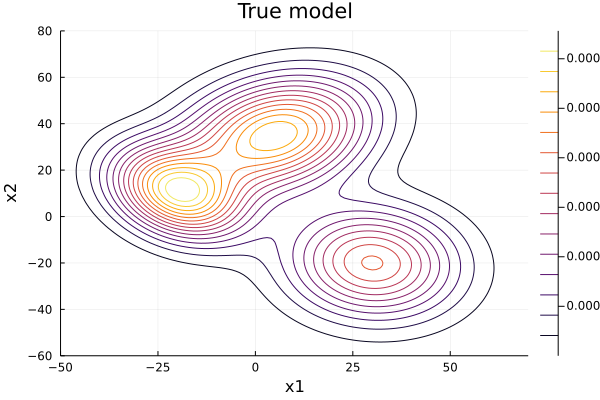

In [3]:
contour(-50:70, -60:80, (x, y) -> pdf(true_model, [x, y]), title="True model", xlabel="x1", ylabel="x2")

## 観測データの生成

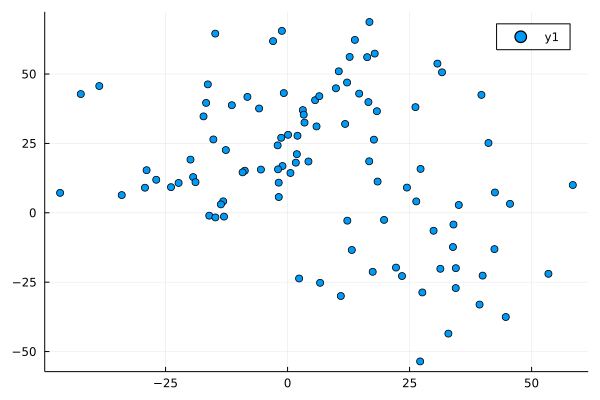

In [4]:
N = 100

μ_obs = [
    [μ₁_true]
    [μ₂_true]
    [μ₃_true]
]

Σ_obs = [
    [Σ₁_true]
    [Σ₂_true]
    [Σ₃_true]
]

mult_obs = Multinomial(1, π_true)
S_obs = rand(mult_obs, N)
cluster_num = mapslices(argmax, S_obs, dims=1)

data = zeros(N, D)
for n in 1:N
    k = cluster_num[n]
    mult_gauss_obs = MvNormal(μ_obs[k], Σ_obs[k])
    data[n, :] = rand(mult_gauss_obs)
end

data[1:10, :]
scatter(data[:, 1], data[:, 2])

クラスターごとに色を変えて表示する。

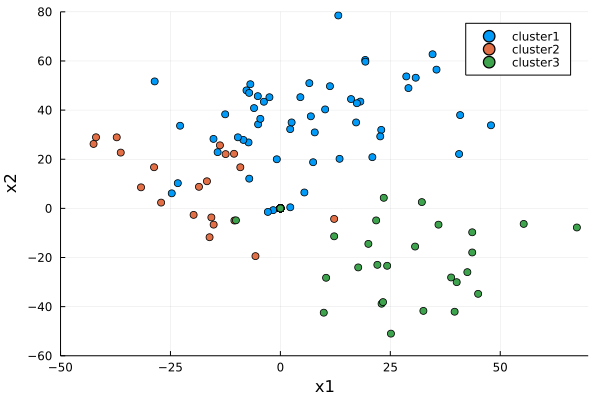

In [5]:
each_cluster = [zeros(D, N), zeros(D, N), zeros(D, N)]
for n in 1:N
    k = cluster_num[n]
    mult_gauss_obs = MvNormal(μ_obs[k], Σ_obs[k])
    each_cluster[k][:, n] = rand(mult_gauss_obs) 
end

p = plot(xlabel="x1", ylabel="x2", xlim=(-50,70), ylim=(-60,80))
for k in 1:K
    scatter!(p, each_cluster[k][1, :], each_cluster[k][2, :], label="cluster$k")
end
p

## ギブスサンプリング

### 受け皿を設定

In [6]:
N = 100
D = 2
K = 3
max_iter = 100

μ_sample = zeros(K, D, max_iter+1)
Λ_sample = zeros(D, D, K, max_iter+1)
π_sample = zeros(max_iter+1, K)

β_sample = zeros(max_iter+1, K)
m_sample = zeros(D, K, max_iter+1)
W_sample = zeros(D, D, K, max_iter+1)
ν_sample = zeros(max_iter+1, K)
α_sample = zeros(max_iter+1, K);

### パラメータのサンプル$\boldsymbol \mu$, $\boldsymbol \Lambda$, $\boldsymbol \pi$に初期値を設定

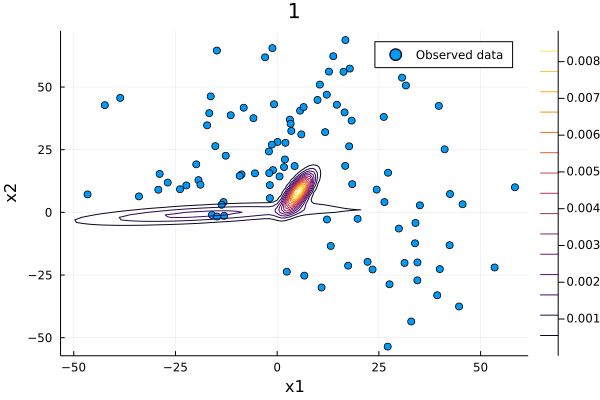

In [7]:
# パラメータの事前分布の超パラメータに初期値を設定
β_sample[1, :] = ones(K)
ν_sample[1, :] = [2.0; 2.0; 2.0]
α_sample[1, :] = ones(K)
m_sample[:, :, 1] = rand(D, K)

for k in 1:K
    W_sample[:, :, k, 1] = Matrix{Float64}(I, D, D) * 0.1
end

# パラメータの事前分布に初期値を設定
for k in 1:K
    wis = Wishart(ν_sample[1, k], PDMat(Symmetric(W_sample[:, :, k, 1])))
    Λ_sample[:, :, k, 1] = rand(wis)
    βΛ = β_sample[1, k] * Λ_sample[:, :, k, 1]
    mult_gauss = MvNormal(m_sample[:, k, 1], PDMat(Symmetric(inv(βΛ))) )
    μ_sample[k, :, 1] = rand(mult_gauss)
end

π_sample[1, :] = rand(Dirichlet(α_sample[1, :]))

# 事前分布を作図
xs = -50:50
p = scatter(data[:, 1], data[:, 2], label="Observed data", title=1)
mg = MvNormal[
    MvNormal(μ_sample[1, :, 1], PDMat(Symmetric(inv(Λ_sample[:, :, 1, 1])))), 
    MvNormal(μ_sample[2, :, 1], PDMat(Symmetric(inv(Λ_sample[:, :, 2, 1])))), 
    MvNormal(μ_sample[3, :, 1], PDMat(Symmetric(inv(Λ_sample[:, :, 3, 1]))))
]
d = MixtureModel(mg, π_sample[1, :])
p = contour!(xs, xs, (x, y) -> pdf(d, [x, y]), xlabel="x1", ylabel="x2")
p

### メイン

In [8]:
for i in 1:max_iter
    # 潜在変数の事後分布のパラメータを計算
    η = zeros(N, K)
    for n in 1:N
        for k in 1:K
            lnη = -0.5 * (data[n, :] - μ_sample[k, :, i])' * Λ_sample[:, :, k, i] * (data[n, :] - μ_sample[k, :, i])
                  + 0.5 * logdet(Λ_sample[:, :, k, i]) + log(π_sample[i, k])
            η[n, k] = exp(lnη - logsumexp(lnη))
        end
    end
    η .= η ./ sum(η, dims=2)　# 正規化
    
    # 潜在変数の事後分布をサンプル
    s_sample = zeros(N, K)
    for n in 1:N
        s_sample[n, :] = rand(Multinomial(1, η[n, :]))
    end
    
    # パラメータμ, Λの事後分布の超パラメータを計算
    β_sample[i+1, :] = vec(sum(s_sample, dims=1)) + β_sample[i, :]
    ν_sample[i+1, :] = vec(sum(s_sample, dims=1)) + ν_sample[i, :]
    for k in 1:K
        m_sample[:, k, i+1] = (1.0 / β_sample[i+1, k]) * (vec(sum(s_sample[n, k] .* data[n, :] for n in 1:N))
            　　　　　　　　　　　+ β_sample[i, k] * m_sample[:, k, i])
        invW = sum(s_sample[n, k] * data[n, :] * data[n, :]' for n in 1:N) 
               + β_sample[i, k] .* m_sample[:, k, i].* m_sample[:, k, i]'
               - β_sample[i+1, k] * m_sample[:, k, i+1] .* m_sample[:, k, i+1]'
               + inv(W_sample[:, :, k, i])
        W_sample[:, :, k, i+1] = inv(invW)  
        
        # パラメータμ, Λの事後分布をサンプル
        wis = Wishart(ν_sample[i+1, k], PDMat(Symmetric(W_sample[:, :, k, i+1])))
        Λ_sample[:, :, k, i+1] = rand(wis)
        βΛ = β_sample[i+1, k] * Λ_sample[:, :, k, i+1]
        mult_gauss = MvNormal(m_sample[:, k, i+1], PDMat(Symmetric(inv(βΛ))))
        μ_sample[k, :, i+1] = rand(mult_gauss)
    end
    
    # 混合比率πの事後分布をサンプル
    α_sample[i+1, :] = vec(sum(s_sample, dims=1)) + α_sample[i, :]
    π_sample[i+1, :] = rand(Dirichlet(α_sample[i+1, :]))
    
    if i % 10 == 1
        println("iteration: $i")
    end
    
    fill!(s_sample, zero(eltype(s_sample)))
    
end


iteration: 1
iteration: 11
iteration: 21
iteration: 31
iteration: 41
iteration: 51
iteration: 61
iteration: 71
iteration: 81
iteration: 91


┌ Info: Saved animation to 
│   fn = /Users/akifumiabe/Julia/BayesMLBook/mult_gauss.gif
└ @ Plots /Users/akifumiabe/.julia/packages/Plots/T6yvp/src/animation.jl:114


Plots.AnimatedGif("/Users/akifumiabe/Julia/BayesMLBook/mult_gauss.gif")
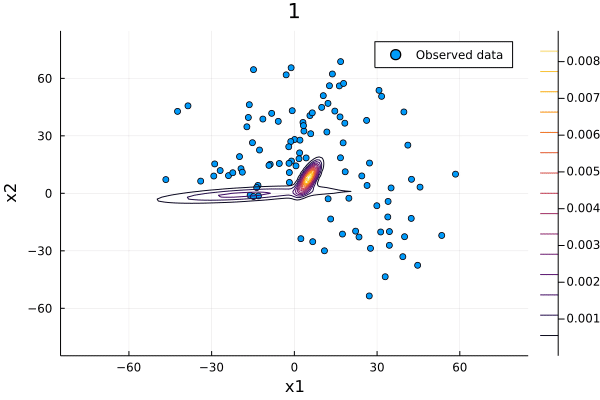

In [9]:
xs = -80:80
anim = @animate for i in 1:max_iter
    p = scatter(data[:, 1], data[:, 2], label="Observed data", title="$i")
    mg = MvNormal[
        MvNormal(μ_sample[1, :, i], PDMat(Symmetric(inv(Λ_sample[:, :, 1, i])))), 
        MvNormal(μ_sample[2, :, i], PDMat(Symmetric(inv(Λ_sample[:, :, 2, i])))), 
        MvNormal(μ_sample[3, :, i], PDMat(Symmetric(inv(Λ_sample[:, :, 3, i]))))
    ]
    d = MixtureModel(mg, π_sample[i, :])
    p = contour!(xs, xs, (x, y) -> pdf(d, [x, y]), xlabel="x1", ylabel="x2")
end

gif(anim, "mult_gauss.gif", fps=5)